In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


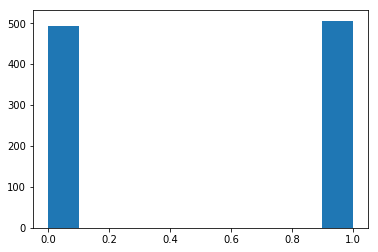

In [2]:
def relu(x): 
    return np.maximum(x, 0, x)
from scipy.special import expit as sigmoid

np.random.seed(50)
n_feature = 100
n_hidden = 10

X_ = np.random.randn(1000, n_feature)
w1_r = np.random.randn(n_feature, n_hidden)
b1_r = np.random.randn(n_hidden,)
a1_r = relu(np.matmul(X_, w1_r) + b1_r)

w2_r = np.random.randn(n_hidden, 1)
b2_r = np.random.randn(1,)
a2_r = sigmoid(np.matmul(a1_r, w2_r) + b2_r)

Y_ = np.random.binomial(1, a2_r).astype('float')
plt.hist(Y_);

In [4]:
import theano
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X_, Y_, test_size=0.25, random_state=42)

In [5]:
X = theano.shared(x_train)
Y = theano.shared(y_train)
with pm.Model() as nn_model:
    w1 = pm.Normal('w1', mu=0, sd=1, shape=(n_feature, n_hidden))
    w2 = pm.Normal('w2', mu=0, sd=1, shape=(n_hidden, 1))
    
    b1 = pm.Normal('b1', mu=0, sd=1, shape=(n_hidden,))
    b2 = pm.Normal('b2', mu=0, sd=1, shape=(1,))
    
    a1 = pm.Deterministic('a1', tt.nnet.relu(tt.dot(X, w1) + b1))
    a2 = pm.Deterministic('a2', tt.nnet.sigmoid(tt.dot(a1, w2) + b2))
    
    out = pm.Bernoulli('likelihood', p=a2, observed=Y)
    
    trace = pm.sample(njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [03:49<00:00,  4.59it/s]


In [6]:
ppc0 = pm.sample_ppc(trace, samples=100, model=nn_model)

100%|██████████| 100/100 [00:00<00:00, 287.45it/s]


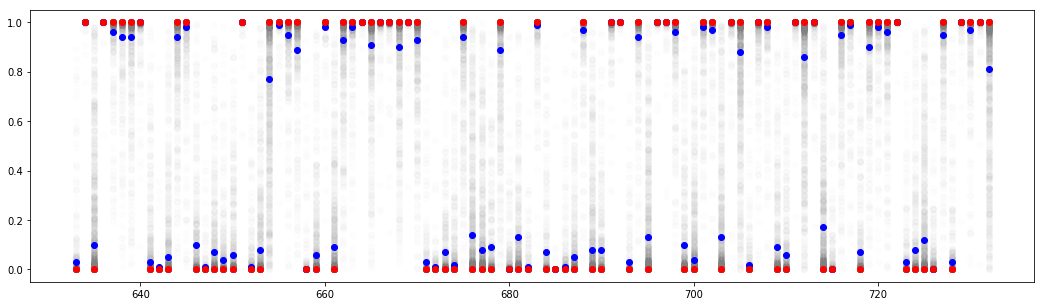

In [11]:
winwidth = 100
randidx = np.random.randint(0, len(y_train)-winwidth)
xrange = np.arange(randidx, randidx+winwidth)

_, ax = plt.subplots(1, 1, figsize=(18, 5))

plt.plot(xrange, trace['a2'][:, xrange, 0].T, 'o', color='gray', alpha=.01)
plt.plot(xrange, ppc0['likelihood'][:, xrange,0].mean(axis=0), 'bo')
plt.plot(xrange, y_train[xrange], 'ro');

In [33]:
bz = 25
X = pm.Minibatch(x_train, batch_size=bz, random_seed=42)
Y = pm.Minibatch(y_train, batch_size=bz, random_seed=42)
with pm.Model() as nn_model:
    w1 = pm.Normal('w1', mu=0, sd=1, shape=(n_feature, n_hidden))
    w2 = pm.Normal('w2', mu=0, sd=1, shape=(n_hidden, 1))
    
    b1 = pm.Normal('b1', mu=0, sd=1, shape=(n_hidden,))
    b2 = pm.Normal('b2', mu=0, sd=1, shape=(1,))
    
    a1 = pm.Deterministic('a1', tt.nnet.relu(tt.dot(X, w1) + b1))
    a2 = pm.Deterministic('a2', tt.nnet.sigmoid(tt.dot(a1, w2) + b2))
    
    out = pm.Bernoulli('likelihood', p=a2, observed=Y, total_size=y_train.shape)

In [36]:
with nn_model:
    inference = pm.ADVI()
    # Local reference to approximation
    approx = inference.approx
    
    inference.fit(100000);

Average Loss = 440.97: 100%|██████████| 100000/100000 [00:55<00:00, 1786.07it/s]
Finished [100%]: Average Loss = 440.7
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 440.7


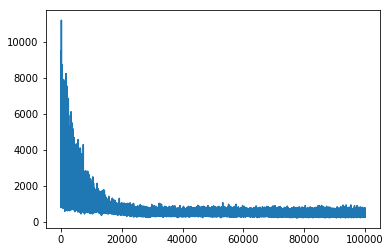

In [37]:
plt.plot(approx.hist);

In [50]:
advimean = nn_model.bijection.rmap(approx.params[0].eval())
a1_advi = relu(np.matmul(X_, advimean['w1']) + advimean['b1'])
a2_advi = sigmoid(np.matmul(a1_advi, advimean['w2']) + advimean['b2'])

In [43]:
with nn_model:
    a1_ = tt.nnet.relu(tt.dot(x_train, w1) + b1)
    a2_ = pm.Deterministic('a2_', tt.nnet.sigmoid(tt.dot(a1_, w2) + b2))
    
    y = pm.Bernoulli('y', p=a2_, shape=y_train.shape)

In [44]:
ppc0 = pm.sample_ppc(trace, samples=1000, model=nn_model, vars=[y])
ppc0['y'].shape

100%|██████████| 1000/1000 [00:01<00:00, 883.11it/s]


(1000, 750, 1)

In [ ]:
# pm.traceplot(trace, varnames=['w2', 'b1', 'b2'],
#              lines=dict(w2=w2_r, b1=b1_r, b2=b2_r));

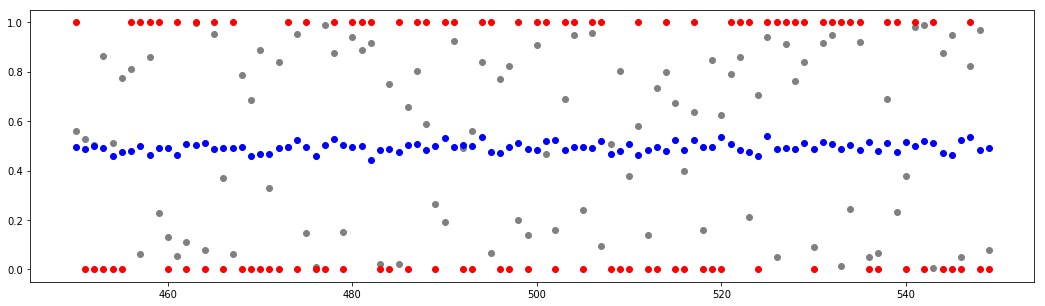

In [51]:
winwidth = 100
randidx = np.random.randint(0, len(y_train)-winwidth)
xrange = np.arange(randidx, randidx+winwidth)

_, ax = plt.subplots(1, 1, figsize=(18, 5))
plt.plot(xrange, a2_advi[xrange], 'o', color='gray')
plt.plot(xrange, ppc0['y'][:, xrange,0].mean(axis=0), 'o', color='blue')
plt.plot(xrange, y_train[xrange], 'ro');

In [23]:
with nn_model:
    inference = pm.ADVI()
    
    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(a2, more_replacements={X: x_test}, size=x_test.shape[0])

    # For train set no more replacements needed
    train_probs = approx.sample_node(a2, more_replacements={X: x_train}, size=x_test.shape[0])

In [24]:
# test_ok = tt.eq(test_probs.argmax(-1), y_test)
# train_ok = tt.eq(train_probs.argmax(-1), y_train)
# test_accuracy = test_ok.mean(-1)
# train_accuracy = train_ok.mean(-1)

# eval_tracker = pm.callbacks.Tracker(
#     test_accuracy=test_accuracy.eval,
#     train_accuracy=train_accuracy.eval
# )

eval_tracker = pm.callbacks.Tracker(
    test_probs=test_probs.eval,
    train_probs=test_probs.eval
)
inference.fit(10000, callbacks=[eval_tracker]);

Average Loss = 3,140.7:   3%|▎         | 333/10000 [00:20<08:37, 18.67it/s]
Interrupted at 334 [3%]: Average Loss = 3,139.5
INFO:pymc3.variational.inference:Interrupted at 334 [3%]: Average Loss = 3,139.5


In [ ]:
# import seaborn as sns
# sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red', alpha=.5)
# sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue', alpha=.5)
# plt.legend(['test_accuracy', 'train_accuracy'])
# plt.title('Training Progress');

In [26]:
trace = inference.approx.sample(1000)

In [30]:
train_probs = approx.sample_node(a2_)

In [31]:
temptr = approx.sample(1000)

KeyError: "'y' not found"